# Kalman Filters
This is an explanation of Kalman filters based on the week 5 probablity lectorial from MCHA4100, where we used a Kalman Filter to filter data from a test.

## Scenario
We've performed *some* test and collected *some* data. The data is stored in a .mat file.


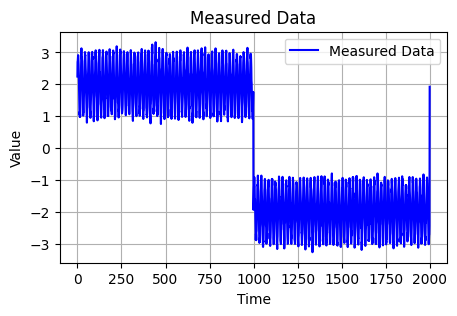

In [29]:
from pathlib import Path
from scipy.io import loadmat
import matplotlib.pyplot as plt

# This assumes you're *inside* the kinematics directory when the notebook runs
data_path = Path("data/data_lectorial5.mat")

assert data_path.exists(), f"Missing file: {data_path.resolve()}"

data = loadmat(data_path)
y = data['y'].flatten()

plt.figure(figsize=(5, 3))
plt.plot(y, 'b', label='Measured Data')
plt.title('Measured Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


From this we can see that there is *a* signal in there but it's been corrupted. Let's analyse the data further to see what's in there.

Dominant Frequency: 0.5 Hz


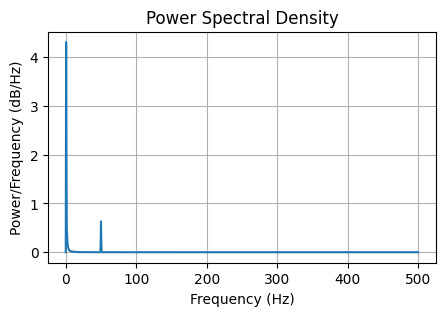

In [30]:
import numpy as np
import scipy.signal as signal

# Define the sampling rate
sampling_rate = 1000  # Assuming the signal was sampled at 1000 Hz

# Perform FFT
frequencies, power_spectrum = signal.welch(y, fs=sampling_rate, nperseg=len(y))

# Find the dominant frequency
dominant_frequency = frequencies[np.argmax(power_spectrum)]

print("Dominant Frequency:", dominant_frequency, "Hz")
# Plot the frequency spectrum
plt.figure(figsize=(5, 3))
plt.plot(frequencies, power_spectrum)
plt.title('Power Spectral Density')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.grid(True)
plt.show()


 After some consultation we've asserted that the corruption is 50 Hz noise with unknown amplitude and phase over the top. There may also be additional added white noise in there as well:

$$y_t = \bar{y}_t + z_t + v_t$$

Where:
- $\bar{y}_t$: Is the unknown (but desired) signal
- $z_t$: Is the 50 Hz noise with unknown amplitude and phase
- $v_t$: Is some added Gaussian noise with zero mean and unit covariance

### 50 Hz noise
A colleague gives us a model for 50 Hz noise from the grid:
$$z_{t+1} + z_{t-1} = 2cos(\omega_0)z_t + w_t$$
Where $\omega_0 = 2 \pi \frac{f_0}{f_s}$ where $f_0$ refers to the frequency of the sinusoidal and $f_s$ is the sampled frequency from the measurement and $w_t$ is additive white noise to account for errors with this model.

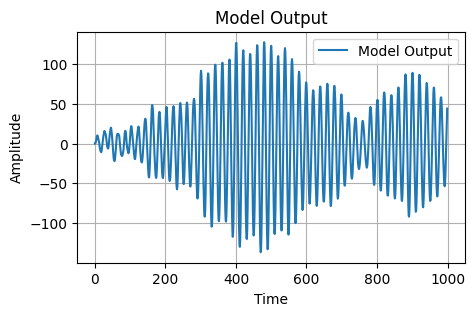

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Define parameters
frequency_0 = 50  # Frequency of the sinusoidal signal in Hz
sampling_frequency = 1000  # Sampling frequency in Hz
num_samples = 1000  # Number of samples

# Compute time vector
t = np.arange(num_samples)

# Compute omega_0
omega_0 = 2 * np.pi * frequency_0 / sampling_frequency  # Angular frequency

# Generate synthetic data using the updated model equation
z = np.zeros(num_samples)
w = np.random.normal(0, 1, num_samples)  # Additive white noise
#w = np.zeros(num_samples)

for i in range(1, num_samples - 1):
    z[i+1] = 2*np.cos(omega_0) * z[i] - z[i-1] + w[i]

# Plot normalized simulated data and actual signal
plt.figure(figsize=(5, 3))
plt.plot(t, z, label='Model Output')
plt.title('Model Output')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()



### Our signal
We expect our signal to be roughly constant but with some independent additive noise:
$$\bar{y}_{t+1} = \bar{y}_{t} + e_t$$

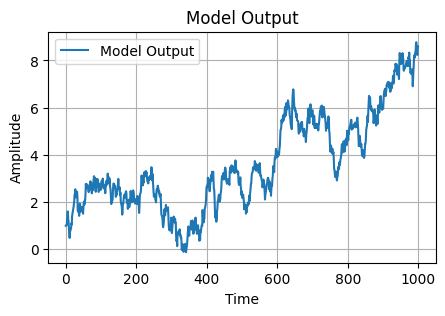

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Compute time vector
t = np.arange(num_samples)
y_bar = np.ones(num_samples)
e = np.random.normal(0, 0.2, num_samples)  # Additive white noise

for i in range(1, num_samples - 1):
    y_bar[i+1] = y_bar[i] + e[i]

# Plot normalized simulated data and actual signal
plt.figure(figsize=(5, 3))
plt.plot(t, y_bar, label='Model Output')
plt.title('Model Output')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

We can plot our whole simulated signal.


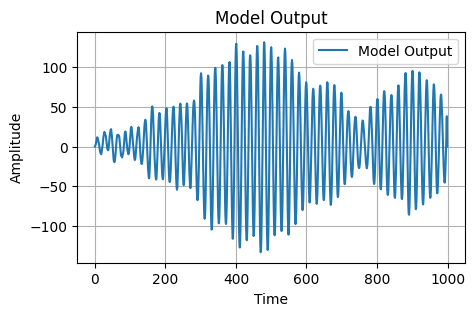

In [33]:
y = np.zeros(num_samples)
v = np.random.normal(0, 0.2, num_samples)

for i in range(1, num_samples - 1):
    y[i] = y_bar[i] + z[i] + v[i]

# Plot normalized simulated data and actual signal
plt.figure(figsize=(5, 3))
plt.plot(t, y, label='Model Output')
plt.title('Model Output')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

While the generated signal doesn't look much like the data with the *right* numbers it could look like it. We can use a Kalman filter to find the right numbers.

## State Space model derivation
To use a Kalman filter we need to convert our models of the different components of the signals into a state space model.

We have:
- A model for our signal: $y_t = \bar{y}_t + z_t + v_t$
- A model for the 50Hz noise: $z_{t+1} + z_{t-1} = 2cos(\omega_0)z_t + w_t$
- A model for expected signal: $\bar{y}_{t+1} = \bar{y} + e_t$

We'll need to track $z_{t+1}$ and $z_{t-1}$ we don't want them directly but we'll need them to calculate $\bar{y}_t$ the thing we actually want.

let x = $\begin{bmatrix} \bar{y}_t\\ z_t \\ z_{t-1}\end{bmatrix}$

We can then rewrite these equations in terms of $x$

For z(t):
$$
\begin{align*}
z_{t+1} + z_{t-1} = 2cos(\omega_0)z_t + w_t\\
\implies x_2[t+1] + x_3 = 2cos(\omega_0)x_2(t) + w_t\\
\implies x_2[t+1] = 2cos(\omega_0)x_2 - x_3 + w_t\\
\implies x_2[t+1] = \begin{bmatrix}0&2cos(\omega_0)&-1\end{bmatrix}\begin{bmatrix}x_1\\x_2\\x_3\end{bmatrix} + \begin{bmatrix}0&1\end{bmatrix}\begin{bmatrix}e_t\\ w_t\end{bmatrix}\\
\end{align*}
$$

For z(t-1):
$$
\begin{align*}
x_3[t+1] = z_t \\
\implies x_3[t+1] = x_2 \\
\implies x_3[t+1] = \begin{bmatrix}0&1&0\end{bmatrix}\begin{bmatrix}x_1\\x_2\\x_3\end{bmatrix} + \begin{bmatrix}0&0\end{bmatrix}\begin{bmatrix}e_t\\ w_t\end{bmatrix}\\
\end{align*}
$$

For y_bar(t):
$$
\begin{align*}
\bar{y}_{t+1} = \bar{y}_{t} + e_t\\
\implies x_1[t+1] = x_1 + e_t \\
\implies x_1[t+1] = \begin{bmatrix}1&0&0\end{bmatrix}\begin{bmatrix}x_1\\x_2\\x_3\end{bmatrix} + \begin{bmatrix}1&0\end{bmatrix}\begin{bmatrix}e_t\\ w_t\end{bmatrix}\\
\end{align*}
$$

We can package these equations into a matrix operation:
$$
\begin{align*}
x_{t+1} = Ax_t + \mathcal{N}\\
\implies \begin{bmatrix}x_1[t+1]\\x_2[t+1]\\x_3[t+1]\end{bmatrix} = A_{3 \times 3} \begin{bmatrix}x_1\\x_2\\x_3\end{bmatrix} + \mathcal{N}\\
\implies \begin{bmatrix}x_1[t+1]\\x_2[t+1]\\x_3[t+1]\end{bmatrix} = \begin{bmatrix} 1&0&0\\0&2cos(\omega_0)&-1\\0&1&0\end{bmatrix} \begin{bmatrix}x_1\\x_2\\x_3\end{bmatrix} + \begin{bmatrix} 1&0\\0&1\\0&0\end{bmatrix}\begin{bmatrix}e_t\\ w_t\end{bmatrix}\\
\end{align*}
$$

Our output is our signal:
$$
\begin{align*}
y_{t+1} = Cx_t + \mathcal{N}\\
\implies y_{t+1} = C_{1 \times 3} \begin{bmatrix}x_1\\x_2\\x_3\end{bmatrix} + \mathcal{N}_{3 \times 1} v_y\\
\implies y_{t+1} = \begin{bmatrix}1&1&0\end{bmatrix} \begin{bmatrix}x_1\\x_2\\x_3\end{bmatrix} + \begin{bmatrix}1\\0\\0\end{bmatrix} v_y\\
\end{align*}
$$

Our final state space equation is:
$$
\begin{align*}
x_{_t+1} = \begin{bmatrix} 1&0&0\\0&2cos(\omega_0)&-1\\0&1&0\end{bmatrix} \begin{bmatrix}x_1\\x_2\\x_3\end{bmatrix} + \begin{bmatrix} 1&0\\0&1\\0&0\end{bmatrix}\begin{bmatrix}e_t\\ w_t\end{bmatrix}\\
y_{t+1} = \begin{bmatrix}1&1&0\end{bmatrix} \begin{bmatrix}x_1\\x_2\\x_3\end{bmatrix} + \begin{bmatrix}1\\0\\0\end{bmatrix} v_y\\
\end{align*}
$$

With this state space equation we can simulate the signal.

C:\Users\jmlgr\AppData\Local\Temp\ipykernel_2172\1707861360.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[t] = np.dot(C, x[:, t]) + vy[t]


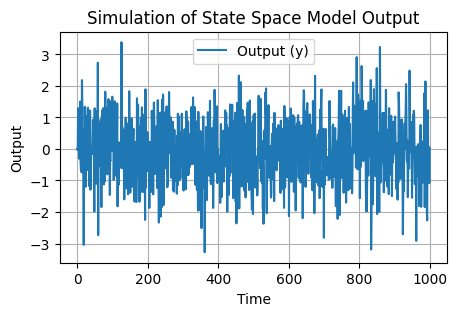

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Define parameters
num_steps = 1000  # Number of time steps
frequency_0 = 50  # Frequency of the sinusoidal signal in Hz
sampling_frequency = 1000  # Sampling frequency in Hz

# Compute omega_0
omega_0 = 2 * np.pi * frequency_0 / sampling_frequency  # Angular frequency

# Define state transition matrix A, input matrices B and C
A = np.array([[1, 0, 0],
              [0, 2 * np.cos(omega_0), -1],
              [0, 1, 0]])


C = np.array([[1, 1, 0]])

# Initialize state vector x, output vector y, and noise matrices
x = np.zeros((3, num_steps))
y = np.zeros(num_steps)
e = np.random.normal(0, 1, num_steps)  # Measurement noise
w = np.random.normal(0, 1, num_steps)  # Process noise
vy = np.random.normal(0, 1, num_steps)  # Output noise

# Simulate forward in time
for t in range(1, num_steps):
    x[:, t] = np.dot(A, x[:, t-1])
    y[t] = np.dot(C, x[:, t]) + vy[t]

# Plot the outcome
plt.figure(figsize=(5, 3))
plt.plot(y, label='Output (y)')
plt.title('Simulation of State Space Model Output')
plt.xlabel('Time')
plt.ylabel('Output')
plt.legend()
plt.grid(True)
plt.show()

## Kalman Filter
All observers have two steps:
1. **Prediction**: Using our model we predict what the next state will be
1. **Update**: After taking a measurement about the state we correct our prediction

The Observer continues in with these steps for all time.

The Kalman Filter (KF) assumes that the model is linear and the states and measurements are all normally distributed.

### States
Our states will be normally distributed.


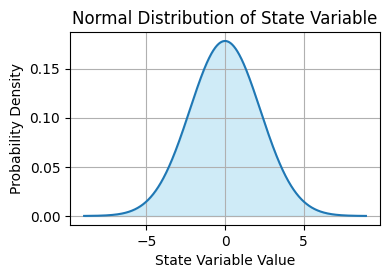

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Assuming the first state variable for simplicity
# Initial state estimate (mean) and standard deviation from the covariance matrix
mean = 0  # Example mean of the first state variable
std_dev = np.sqrt(5)  # Square root of the covariance for the first state variable

# Define range for plotting
x_range = np.linspace(mean - 4*std_dev, mean + 4*std_dev, 1000)

# Normal distribution for the state
y_values = norm.pdf(x_range, mean, std_dev)

# Plotting
plt.figure(figsize=(4, 2.5))
plt.plot(x_range, y_values, label='State Variable Distribution')
plt.fill_between(x_range, y_values, color='skyblue', alpha=0.4)
plt.title('Normal Distribution of State Variable')
plt.xlabel('State Variable Value')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()


When we do a prediction we're passing our normally distributed state through a linear function:
$$x_{k+1} = f(x_k)$$
When we do this we end up with another normal distribution.


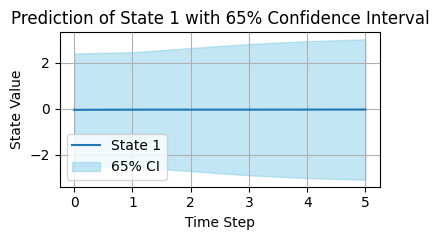

In [36]:
Q = np.diag([1, 1, 0])
# Measurement noise covariance
R = np.array([[0.5]])

xhm0 = np.array([[y[1]], [0], [0]])  # initial guess for state
Pm = 5 * np.eye(3)  # initial estimate error covariance


# Simulated Kalman update step
I = np.eye(3)

xhm = np.dot(A, xhm0)
Pm = np.dot(np.dot(A, Pm), A.T) + Q

# Number of time steps to predict forward
time_steps = 5

# Arrays to store predictions and covariances
xhms = np.zeros((3, time_steps + 1))
Pms = np.zeros((3, time_steps + 1))

# Store initial state and covariance
xhms[:, 0] = xhm.flatten()
Pms[:, 0] = np.diag(Pm)

# Perform predictions
for i in range(1, time_steps + 1):
    # Predict state forward
    xhm = np.dot(A, xhm)
    # Predict covariance forward
    Pm = np.dot(np.dot(A, Pm), A.T) + Q

     # Measurement update
    y_pred = C @ xhm
    residual = y[t] - y_pred

    S = C @ Pm @ C.T + R
    K = Pm @ C.T @ np.linalg.inv(S)

    xhm = xhm + K @ residual
    Pm = (I - K @ C) @ Pm

    # Store predictions
    xhms[:, i] = xhm.flatten()
    Pms[:, i] = np.diag(Pm)

# Plotting
plt.figure(figsize=(4, 2.5))
time = np.arange(time_steps + 1)
std_dev = np.sqrt(Pms[0, :])  # Standard deviation for State 1
plt.plot(time, xhms[0, :], label='State 1')
plt.fill_between(time, xhms[0, :] - std_dev, xhms[0, :] + std_dev, color='skyblue', alpha=0.5, label='65% CI')

# Corrected method names for setting title, xlabel, and ylabel
plt.title('Prediction of State 1 with 65% Confidence Interval')
plt.xlabel('Time Step')
plt.ylabel('State Value')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

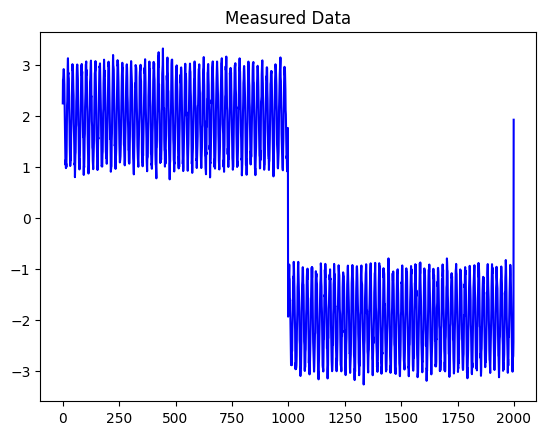

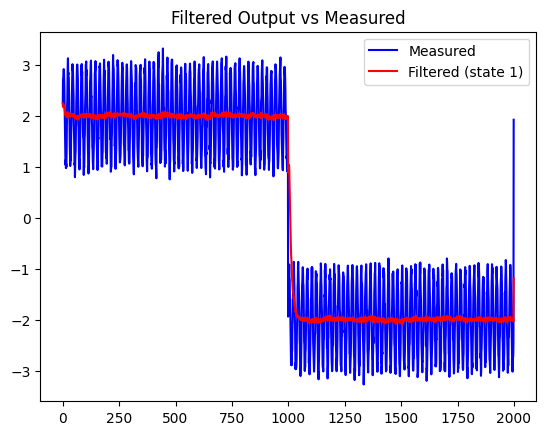

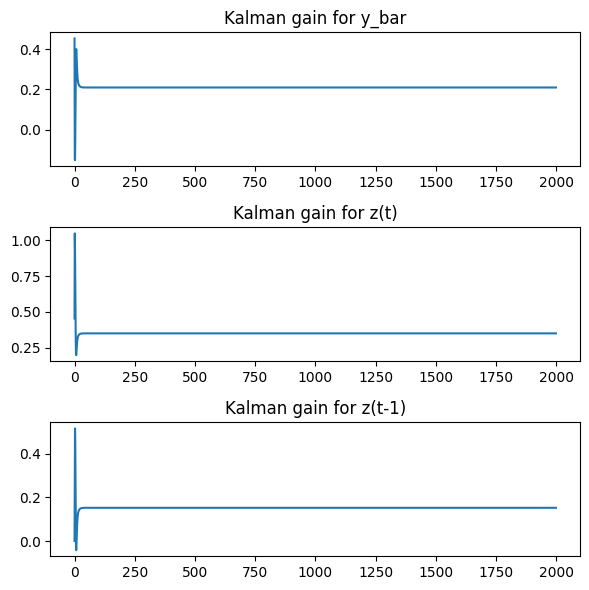

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

# --- Load data ---
data = loadmat("data/data_lectorial5.mat")
y = data["y"].flatten()

# --- Parameters ---
f0 = 50
fs = 1000
a = 2 * np.cos(2 * np.pi * f0 / fs)

Ad = np.array([
    [1, 0, 0],
    [0, a, -1],
    [0, 1, 0]
])
C = np.array([[1, 1, 0]])

# --- Initialization ---
N = len(y)
xhm = np.array([[y[0]], [0], [0]])  # Initial state estimate
Pm = 5 * np.eye(3)                  # Initial covariance

Q = np.diag([0.1, 0, 0.1])          # Process noise
R = 1                               # Measurement noise

xh = np.zeros((N, 3))               # Filtered states
KK_data = np.zeros((N, 3))          # Kalman gain over time
Pm_data = np.zeros((N, 3))          # Covariance diagonals

# --- Kalman Filter Loop ---
for i in range(N):
    # Correction
    S = C @ Pm @ C.T + R
    Kk = Pm @ C.T @ np.linalg.inv(S)
    
    y_i = y[i]
    xhp = xhm + Kk @ (y_i - C @ xhm)
    
    Pp = (np.eye(3) - Kk @ C) @ Pm @ (np.eye(3) - Kk @ C).T + Kk * R * Kk.T

    # Prediction
    xhm = Ad @ xhp
    Pm = Ad @ Pp @ Ad.T + Q

    # Store
    xh[i, :] = xhp.flatten()
    KK_data[i, :] = Kk.flatten()
    Pm_data[i, :] = np.diag(Pm)

# --- Plotting ---
plt.figure()
plt.plot(y, 'b', label='Measured')
plt.plot(xh[:, 0], 'r', label='Filtered (state 1)')
plt.title('Filtered Output vs Measured')
plt.legend()

# Kalman gain plots
fig, axes = plt.subplots(3, 1, figsize=(6, 6))
axes[0].plot(KK_data[:, 0])
axes[0].set_title("Kalman gain for y_bar")
axes[1].plot(KK_data[:, 1])
axes[1].set_title("Kalman gain for z(t)")
axes[2].plot(KK_data[:, 2])
axes[2].set_title("Kalman gain for z(t-1)")
plt.tight_layout()
plt.show()
